In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import torch
import torch.nn.functional as F
from overfit.models.primingnet import PrimingNet
from overfit.utils.img2vid import zigzag, display_video
from PIL import Image
import torchvision.transforms.functional as FT
from torchvision.models import resnet152, ResNet152_Weights
import matplotlib
import matplotlib.pyplot as plt
import mlflow


In [3]:
%matplotlib widget

In [27]:
srcnet = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1).eval()

69


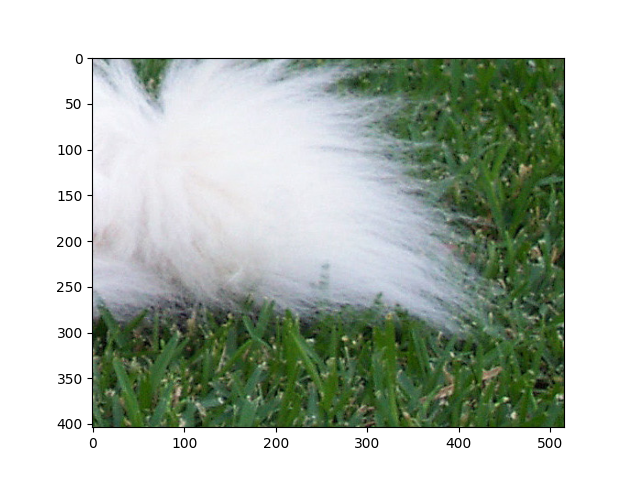

In [24]:
input_image = Image.open("dog.jpg")
input_tensor = FT.to_tensor(input_image)
_, h, w = input_tensor.size()
input_video = zigzag(input_tensor, h // 3, w // 3)
vid = display_video(input_video)
# vid.save("dog.mp4")
print(len(input_video))
# plt.show()


In [25]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

Samoyed tensor(0.0652)
white wolf tensor(0.0412)
Samoyed tensor(0.0910)
Samoyed tensor(0.1074)
Samoyed tensor(0.1156)
Samoyed tensor(0.1012)
Samoyed tensor(0.1019)
white wolf tensor(0.0944)
white wolf tensor(0.0849)
white wolf tensor(0.0262)
white wolf tensor(0.0122)
white wolf tensor(0.0112)
skunk tensor(0.0027)
skunk tensor(0.0011)
skunk tensor(0.0006)
armadillo tensor(0.0002)
armadillo tensor(0.0001)
red fox tensor(0.0001)
red fox tensor(7.6767e-05)
red fox tensor(7.8380e-05)
red fox tensor(5.3546e-05)
armadillo tensor(6.6670e-05)
red fox tensor(7.0552e-05)
hare tensor(0.0002)
hare tensor(0.0002)
hare tensor(0.0005)
hare tensor(0.0031)
hare tensor(0.0048)
skunk tensor(0.0083)
skunk tensor(0.0131)
skunk tensor(0.0259)
Angora tensor(0.0429)
Angora tensor(0.0599)
Angora tensor(0.0714)
Angora tensor(0.0878)
Angora tensor(0.0788)
Angora tensor(0.0826)
Angora tensor(0.0726)
Angora tensor(0.0843)
Angora tensor(0.0991)
Angora tensor(0.0933)
Angora tensor(0.0525)
Angora tensor(0.0358)
Angora

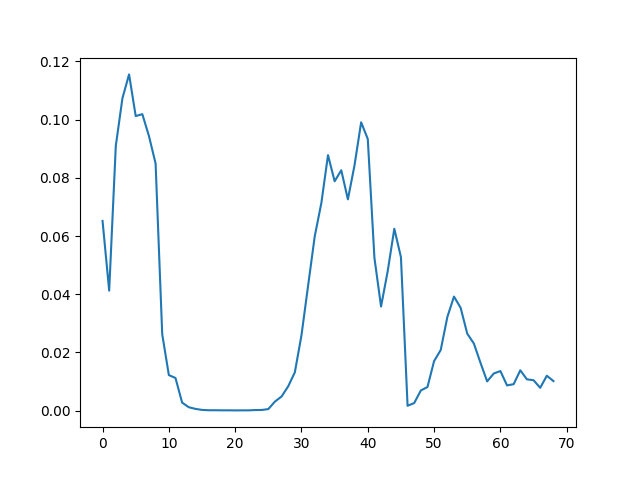

In [28]:
def normalize_rgb(img):
    return FT.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


correct_img = 258
correct_ts = []
for ix, img in enumerate(input_video):
    img = normalize_rgb(img)
    img_batch = img.unsqueeze(0)
    with torch.no_grad():
        out = srcnet(img_batch)
    probabilities = F.softmax(out[0], dim=0)
    correct_ts.append(probabilities[correct_img])
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    print(categories[top5_catid[0]],probabilities[correct_img])

fig = plt.figure()
plt.plot(correct_ts)
plt.show()

Samoyed tensor(0.0652, grad_fn=<SelectBackward0>)
white wolf tensor(0.0424, grad_fn=<SelectBackward0>)
Samoyed tensor(0.0975, grad_fn=<SelectBackward0>)
Samoyed tensor(0.1254, grad_fn=<SelectBackward0>)
Samoyed tensor(0.1585, grad_fn=<SelectBackward0>)
Samoyed tensor(0.1884, grad_fn=<SelectBackward0>)
Samoyed tensor(0.2730, grad_fn=<SelectBackward0>)
Samoyed tensor(0.4074, grad_fn=<SelectBackward0>)
Samoyed tensor(0.6003, grad_fn=<SelectBackward0>)
Samoyed tensor(0.7581, grad_fn=<SelectBackward0>)
Samoyed tensor(0.9182, grad_fn=<SelectBackward0>)
Samoyed tensor(0.9885, grad_fn=<SelectBackward0>)
Samoyed tensor(0.9958, grad_fn=<SelectBackward0>)
Samoyed tensor(0.9963, grad_fn=<SelectBackward0>)
Samoyed tensor(0.9886, grad_fn=<SelectBackward0>)
Samoyed tensor(0.8616, grad_fn=<SelectBackward0>)
Samoyed tensor(0.1805, grad_fn=<SelectBackward0>)
armadillo tensor(0.0047, grad_fn=<SelectBackward0>)
armadillo tensor(2.6505e-05, grad_fn=<SelectBackward0>)
red fox tensor(2.1332e-07, grad_fn=<Sel

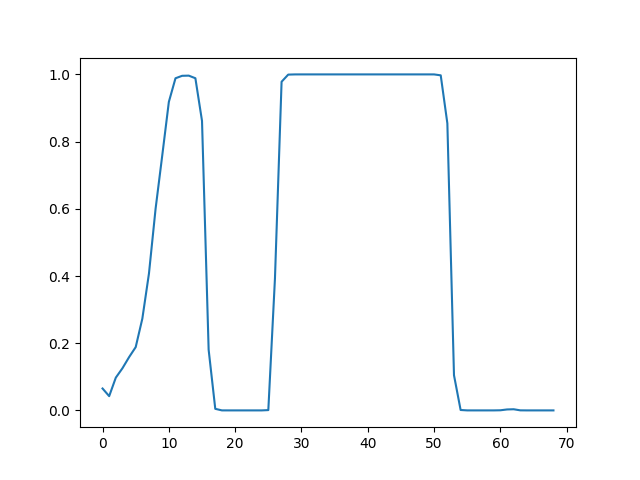

In [167]:
def normalize_rgb(img):
    return FT.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


mlflow.set_experiment(experiment_name="test")
weight_decay = 40
lr_scale = 0.01
momentum = 1.0
mlflow.log_param("weight_decay", weight_decay)
mlflow.log_param("lr_scale", lr_scale)
mlflow.log_param("momentum", momentum)
tgtnet = PrimingNet(
    pretrained_classifier=srcnet,
    weight_decay=weight_decay,
    lr_scale=lr_scale,
    momentum=momentum,
)
correct_img = 258
correct_ts = []
for ix, img in enumerate(input_video):
    img = normalize_rgb(img)
    img_batch = img.unsqueeze(0)
    out = tgtnet(img_batch, correct_img, ix)
    probabilities = F.softmax(out[0], dim=0)
    correct_ts.append(probabilities[correct_img].detach().numpy())
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    print(categories[top5_catid[0]], probabilities[correct_img])

fig = plt.figure()
plt.plot(correct_ts)
plt.show()
mlflow.end_run()


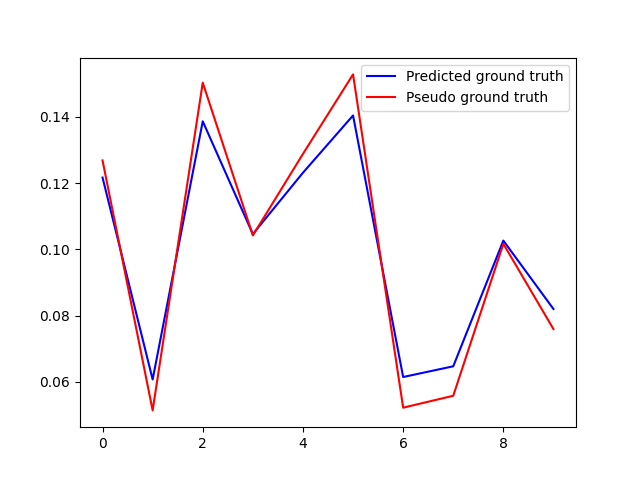

In [21]:
plt.figure()

plt.plot(F.softmax(x, dim=0), c='b', label="Predicted ground truth")
plt.plot(F.softmax(1.3 * x, dim=0), c='r', label="Pseudo ground truth")
plt.legend()
plt.show()

In [47]:
x = (torch.rand(10) + 1) * 5
print(x)
y = F.softmax(x, dim=0)
print(y)
print(torch.log()+ torch.log(torch.sum(torch.exp(x))))


tensor([9.8586, 5.7425, 7.8527, 6.2784, 8.4223, 7.5454, 6.6939, 8.6387, 8.2896,
        7.7778])
tensor([0.4575, 0.0075, 0.0615, 0.0127, 0.1088, 0.0453, 0.0193, 0.1351, 0.0953,
        0.0571])
tensor([9.8586, 5.7425, 7.8527, 6.2784, 8.4223, 7.5454, 6.6939, 8.6387, 8.2896,
        7.7778])


In [49]:

F.softmax(y, dim=0)

tensor([0.1417, 0.0904, 0.0954, 0.0909, 0.1000, 0.0939, 0.0915, 0.1027, 0.0987,
        0.0950])

# Plots

In [146]:
from torchvision.utils import save_image
for i in range(0, 12, 2):
    save_image(input_video[i], f'dog{i}.png')

## Priming

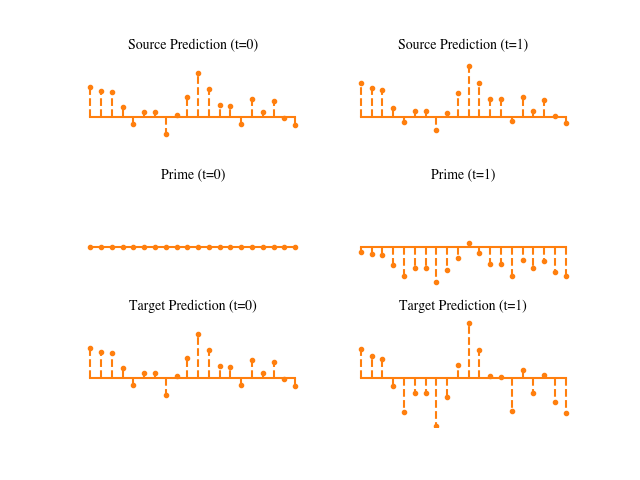

In [141]:
srcnet = resnet152(weights=ResNet152_Weights.IMAGENET1K_V1).eval()
tgtnet = PrimingNet(
    pretrained_classifier=srcnet,
    weight_decay=30,
    lr_scale=0.5,
    momentum=0,
)

delta = 10
l = 258 - delta
r = 258 + delta
x = input_video[0].unsqueeze(0)
fig, axes = plt.subplots(3, 2)
for i in range(2):
    x = input_video[i].unsqueeze(0)
    # p = F.softmax(tgtnet.prime, dim=0).detach().numpy().copy()[l:r]
    # y_src = F.softmax(srcnet(x), dim=1).detach().numpy()[0].copy()[l:r]
    # y_tgt = F.softmax(tgtnet(x), dim=1).detach().numpy()[0].copy()[l:r]
    p = tgtnet.prime.detach().numpy().copy()[l:r]
    xticks = range(r - l)
    y_src = srcnet(x).detach().numpy()[0].copy()[l:r]
    y_tgt = tgtnet(x).detach().numpy()[0].copy()[l:r]
    axes[0, i].set_title(f"Source Prediction (t={i})", {'fontname': 'Times', 'fontsize': 10})
    axes[1, i].set_title(f"Prime (t={i})", {'fontname': 'Times', 'fontsize': 10})
    axes[2, i].set_title(f"Target Prediction (t={i})", {'fontname': 'Times', 'fontsize': 10})
    axes[0, i].set_ylim([-5, 6])
    axes[1, i].set_ylim([-5, 6])
    axes[2, i].set_ylim([-5, 6])
    axes[0, i].axis('off')
    axes[1, i].axis('off')
    axes[2, i].axis('off')
    axes[0, i].stem(xticks, y_src, linefmt='C1--', basefmt='C1-', markerfmt='C1.')
    axes[1, i].stem(xticks, p, linefmt='C1--', basefmt='C1-', markerfmt='C1.')
    axes[2, i].stem(xticks, y_tgt, linefmt='C1--', basefmt='C1-', markerfmt='C1.')

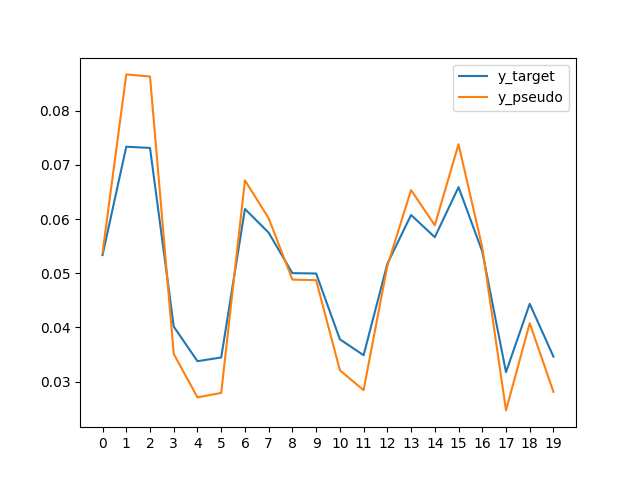

In [155]:

n = 20
l = torch.rand(n)
y = F.softmax(l, dim=0)
p = F.softmax(l * 1.5, dim=0)
xticks = list(range(n))
plt.figure()
plt.plot(y, label="y_target")
plt.plot(p, label="y_pseudo")
plt.legend()
plt.xticks(xticks)
plt.show()